### This trains a model to classify movie reviews as positive or negative and tries to predict that on new reviews

In [1]:
import pandas as pd, numpy as np
from textblob import TextBlob, Word, Blobber
from sklearn import metrics
import unicodedata, sys, re, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer    

In [2]:
mr=pd.read_csv('labeledtraindata.tsv', sep='\t')
stops=stopwords.words('english')

review_lower=[mr['review'][x].lower() for x in range(25000)]
p=re.compile(r'[^\w\s]+')

review_lower_nopunct2=[p.sub('', x) for x in review_lower]

In [3]:
review_lower_nopunct2[450]

'to heighten the drama of this sudsy maternity ward story its set in a special ward for difficult cases the main story is loretta youngs shes on leave from a long prison stretch for murder will the doctors save her baby at the cost of her life or heed her husbands plea for the opposite melodrama and sentiment are dominant and theyre not the honest sort to say the least for example just to keep things moving this hospital has a psycho ward next door to the maternity ward and lets a woman with a hysterical pregnancy wander about stealing babiesbr br there are just enough laughs and sarcasm for this to be recognizable as a warners film mostly from glenda farrell who swigs gin from her hotwater bottle while she waits to have twins that to her chagrin she finds theres now a law against selling an example of her repartee be careful farrell its too late to be careful aline macmahon is of course wonderfully authoritative as the chief nurse but dont expect her to be given a dramatic momentbr br

In [4]:
from datetime import datetime

In [6]:
porter=PorterStemmer()

tbstemmed=[]
for y in range (25000):
    tbstemmed.append(str(' '.join([porter.stem(x) for x in TextBlob(nostops[y]).words])) )
    

In [7]:
rs=tbstemmed

First let's see what we're dealing with.

In [8]:
mr.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

ok, half positive and half negative.

In [9]:
from sklearn.model_selection import train_test_split
rs_train,rs_test,target_train,target_test=train_test_split(rs, mr.sentiment, test_size=.2, random_state=1)

In [10]:
#from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
tfidf_vect=TfidfVectorizer()

#tfidf_tran=TfidfTransformer()

In [11]:
rs_train_tf=tfidf_vect.fit_transform(rs_train)

In [14]:
rs_test_tf=tfidf_vect.transform(rs_test)
rs_test_tf.shape

(5000, 81184)

#### Training a logistic regression using the training data.

In [15]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1)
movreviewmodel=logreg.fit(rs_train_tf, target_train)

In [16]:
movreviewmodel.score(rs_train_tf, target_train)

0.9313

That is the R-squared score on the TRAINING set, but I wanted to do that just out of curiosity. Now for the test set:

In [17]:
movreviewmodel.score(rs_test_tf, target_test)

0.8864

I suppose it's pretty good.

In [18]:
test_pred=movreviewmodel.predict(rs_test_tf)

In [19]:
metrics.confusion_matrix(target_test,test_pred)

array([[2187,  316],
       [ 252, 2245]], dtype=int64)

So there were relatively few false negatives (252), somewhat more false positives (316), but generally good semantic analysis.

In [20]:
from sklearn.metrics import r2_score, recall_score, f1_score, classification_report, precision_recall_fscore_support

In [21]:
print('precision of model: ',metrics.precision_score(target_test,test_pred))

precision of model:  0.8766106989457243


In [22]:
print('Recall (Sensitivity) score: ',metrics.recall_score(target_test,test_pred))

Recall (Sensitivity) score:  0.8990788946736084


In [23]:
print('Recall (Specificity) score: ',metrics.recall_score(target_test,test_pred, pos_label=0))

Recall (Specificity) score:  0.8737514982021574


In [24]:
print('F1 score: ',metrics.f1_score(target_test,test_pred))

F1 score:  0.8877026492684855


It's easier to use the Classification report:

In [25]:
print(metrics.classification_report(target_test,test_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2503
           1       0.88      0.90      0.89      2497

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

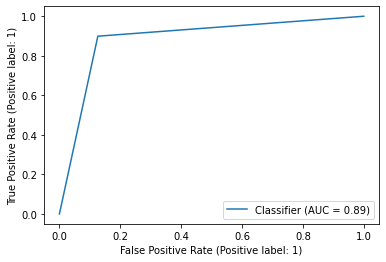

In [27]:
RocCurveDisplay.from_predictions(target_test, test_pred)

Let's see how the Random Forest Classifier did:

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier()
movieforest=forest.fit(rs_train_tf, target_train)

In [29]:
y_forest_pred=forest.predict(rs_test_tf)
metrics.confusion_matrix(target_test,y_forest_pred)

array([[2137,  366],
       [ 405, 2092]], dtype=int64)

In [30]:
print('precision of model: ',metrics.precision_score(target_test,y_forest_pred))
print('Recall (Sensitivity) score: ',metrics.recall_score(target_test,y_forest_pred))
print('Recall (Specificity) score: ',metrics.recall_score(target_test,y_forest_pred, pos_label=0))
print('F1 score: ',metrics.f1_score(target_test,y_forest_pred))
print(metrics.classification_report(target_test,y_forest_pred))


precision of model:  0.8510984540276648
Recall (Sensitivity) score:  0.8378053664397277
Recall (Specificity) score:  0.853775469436676
F1 score:  0.8443995963673058
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2503
           1       0.85      0.84      0.84      2497

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



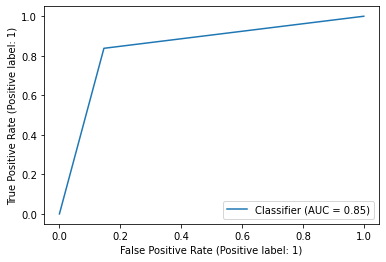

In [31]:
RocCurveDisplay.from_predictions(target_test, y_forest_pred)

So, not as good as the logistic regressor!  
Let's try the Naive Bayes Complement regressor (Although there are several versions of the NB, I chose the Complement Naive Bayes method since it is reputed to be better on text classification tasks:

In [32]:
from sklearn.naive_bayes import ComplementNB
nb=ComplementNB()
movienb=nb.fit(rs_train_tf, target_train)

In [33]:
y_nb_pred=nb.predict(rs_test_tf)
metrics.confusion_matrix(target_test,y_nb_pred)

array([[2178,  325],
       [ 356, 2141]], dtype=int64)

In [34]:
print('precision of model: ',metrics.precision_score(target_test,y_nb_pred))
print('Recall (Sensitivity) score: ',metrics.recall_score(target_test,y_nb_pred))
print('Recall (Specificity) score: ',metrics.recall_score(target_test,y_nb_pred, pos_label=0))
print('F1 score: ',metrics.f1_score(target_test,y_nb_pred))
print(metrics.classification_report(target_test,y_nb_pred))

precision of model:  0.8682076236820763
Recall (Sensitivity) score:  0.8574289146976372
Recall (Specificity) score:  0.8701558130243707
F1 score:  0.8627846060850293
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2503
           1       0.87      0.86      0.86      2497

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



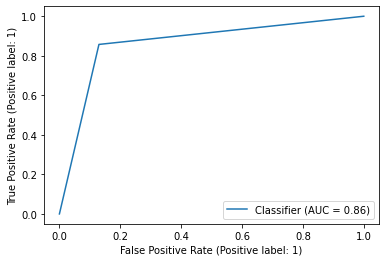

In [35]:
RocCurveDisplay.from_predictions(target_test, y_nb_pred)

So better than the Random Forest, but not as accurate as the Logistic regressor!  
Let's try an unsupervised method (this is more amazing, since we don't tell it which are positive and which are negative to train it!)

In [36]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2, random_state=1)
moviekm=km.fit(rs_train_tf)

In [37]:
y_km_pred=nb.predict(rs_test_tf)
metrics.confusion_matrix(target_test,y_km_pred)

array([[2178,  325],
       [ 356, 2141]], dtype=int64)

In [38]:
print('precision of model: ',metrics.precision_score(target_test,y_km_pred))
print('Recall (Sensitivity) score: ',metrics.recall_score(target_test,y_km_pred))
print('Recall (Specificity) score: ',metrics.recall_score(target_test,y_km_pred, pos_label=0))
print('F1 score: ',metrics.f1_score(target_test,y_km_pred))
print(metrics.classification_report(target_test,y_km_pred))

precision of model:  0.8682076236820763
Recall (Sensitivity) score:  0.8574289146976372
Recall (Specificity) score:  0.8701558130243707
F1 score:  0.8627846060850293
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2503
           1       0.87      0.86      0.86      2497

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



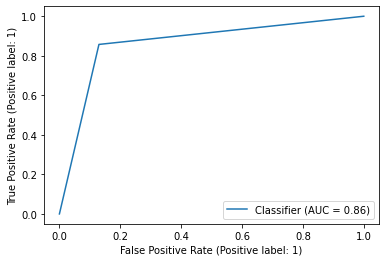

In [39]:
RocCurveDisplay.from_predictions(target_test, y_km_pred)

So it's pretty good without being told which is positive and which is negative!  
Still , the best model was the Logistic Regression.